In [1]:
import configparser
import json
import spotipy
import spotipy.util as util
import pandas as pd
import spotipy.oauth2 as oauth2
from spotipy.oauth2 import SpotifyClientCredentials
import bamboolib
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [5]:
with open('../data/raw/spotify_creds.json') as f:
    spotify_creds = json.load(f)

with open('../data/raw/spotify_token.json') as f:
    spotify_token = json.load(f)

client_id = spotify_creds['client_id']
client_secret = spotify_creds['client_secret']
username = spotify_creds['username']
scope = spotify_creds['saved_library_scope']
redirect_uri = spotify_creds['saved_library_redirect_url']
#token = spotify_token['all_access_token']


def connect_to_spotify_api(client_id, client_secret, username, scope, redirect_uri):
    
    client_credentials_manager = SpotifyClientCredentials(client_id, client_secret) 
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)
    if token:
        sp = spotipy.Spotify(auth=token)
    else:
        print("Can't get token for", username)
        
    return sp

sp = connect_to_spotify_api(client_id, client_secret, username, scope, redirect_uri)

In [49]:
def get_saved_library():
    
    df_saved_tracks = pd.DataFrame()
    track_list = ''
    added_ts_list = []
    artist_list = []
    artist_url_list = []
    title_list = []
    popularity_list = []
    album_cover_list = []
    track_url_list = []
    more_songs = True
    offset_index = 0

    while more_songs:
        songs = sp.current_user_saved_tracks(offset=offset_index)
        for song in songs['items']:
            #join track ids to a string for audio_features function
            track_list += song['track']['id'] +','
            #get the time when the song was added
            added_ts_list.append(song['added_at'])
            #get the title of the song
            title_list.append(song['track']['name'])
            #get popularity
            popularity_list.append(song['track']['popularity'])
            album_cover_list.append(song['track']['album']['images'][0]['url'])
            # get track list
            track_url = song['track']['external_urls']['spotify']
            track_url = track_url.split('/')[-1]
            track_url_list.append(track_url)
            #get all the artists in the song
            artists = song['track']['artists']
            artists_name = ''
            for artist in artists:
                artists_name += artist['name']  + ','
            artist_list.append(artists_name[:-1])
            # aritst_url
            artists = song['track']['artists']
            artists_urls = ''
            for artist in artists:
                artist_url = artist['external_urls']['spotify']
                artist_url = artist_url.split('/')[-1]
                artists_urls += artist_url  + ','
            artist_url_list.append(artists_urls[:-1])
            
        track_features = sp.audio_features(track_list[:-1])
        df_temp = pd.DataFrame(track_features)
        df_temp = df_temp[['acousticness', 'danceability', 'energy', 'speechiness', 'valence', 'tempo']]
        df_temp = df_temp.rename(columns={'tempo': 'BPM'})
        df_saved_tracks = df_saved_tracks.append(df_temp)
        track_list = ''
        if songs['next'] == None:
            # no more songs in playlist
            more_songs = False
        else:
            # get the next n songs
            offset_index += songs['limit']
    #include timestamp added, title and artists of a song
    df_saved_tracks['song_title'] = title_list
    df_saved_tracks['artists'] = artist_list
    df_saved_tracks['artists_url'] = artist_url_list
    df_saved_tracks['date_added'] = added_ts_list
    df_saved_tracks['album_cover'] = album_cover_list
    df_saved_tracks['popularity'] = popularity_list
    df_saved_tracks['date_added'] = df_saved_tracks['date_added'].apply(lambda x: x.split('T')[0])
    df_saved_tracks['url'] = track_url_list
    df_saved_tracks['date_added'] = pd.to_datetime(df_saved_tracks['date_added'], infer_datetime_format=True)
    df_saved_tracks['date_added_year'] = df_saved_tracks['date_added'].dt.year
    
    return df_saved_tracks

In [50]:
df_saved = get_saved_library()
#df_saved[['BPM']] = NormalizeData(df_saved[['BPM']])

In [61]:
df_saved.to_csv('df_saved.csv',index=False)

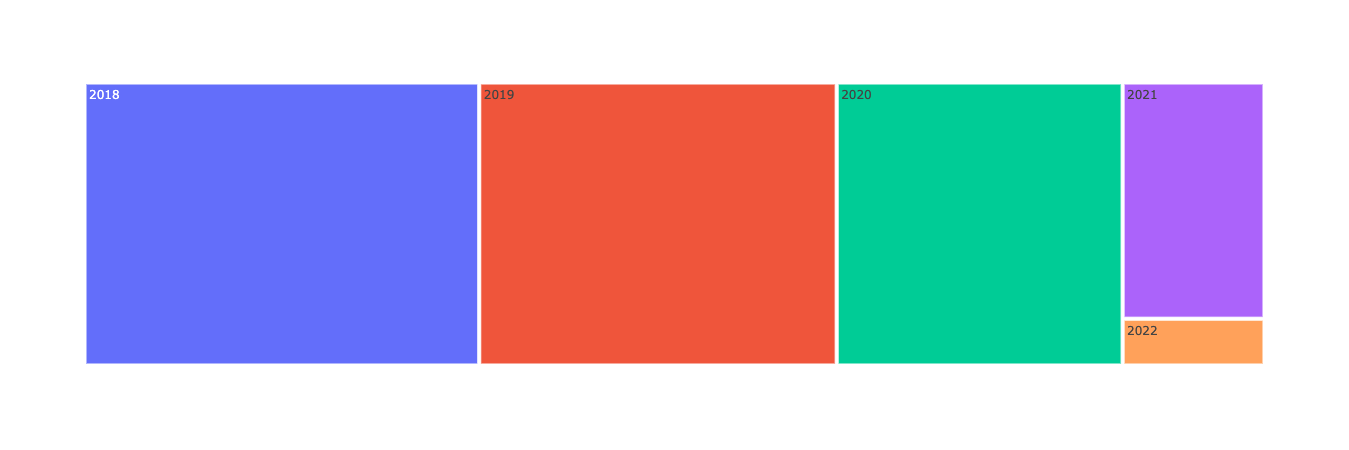

In [65]:
import plotly.express as px
fig = px.treemap(df_saved, path=['date_added_year'])
fig

In [52]:
artist_list = []

for i in range(len(df_saved)):
    artists = df_saved.iloc[i]['artists_url']
    for artist in artists.split(','):
        artist_list.append(artist)
        
artist_list = set(artist_list)

In [59]:
df_artist_genre = pd.DataFrame()
aritst_name_list = []
aritst_genre_list = []

for i in artist_list:
    aritst_name = sp.artist(i)['name']
    #print(aritst_name)
    aritst_genre = sp.artist(i)['genres']
    aritst_name_list.append(aritst_name)
    aritst_genre_list.append(aritst_genre)
    
df_artist_genre['name'] = aritst_name_list
df_artist_genre['genre'] = aritst_genre_list

In [68]:
df_artist_detailed_genre = pd.DataFrame()
aritst_name_list = []
aritst_genre_list = []

for i in range(len(df_artist_genre)):
    artist = df_artist_genre.iloc[i]['name']
    genre_list = df_artist_genre.iloc[i]['genre']
    for genre in genre_list:
        aritst_name_list.append(artist)
        aritst_genre_list.append(genre)
        
df_artist_detailed_genre['name'] = aritst_name_list
df_artist_detailed_genre['genre'] = aritst_genre_list

In [79]:
top_genre = df_artist_detailed_genre['genre'].value_counts().reset_index().head(5)
top_genre = top_genre.rename(columns={'index': 'genre', 'genre': 'count'})
top_genre_list = top_genre['genre'].unique()

In [84]:
df_artist_detailed_genre['genre_new'] = df_artist_detailed_genre['genre'].apply(lambda x : x if x in top_genre_list else 'Other')

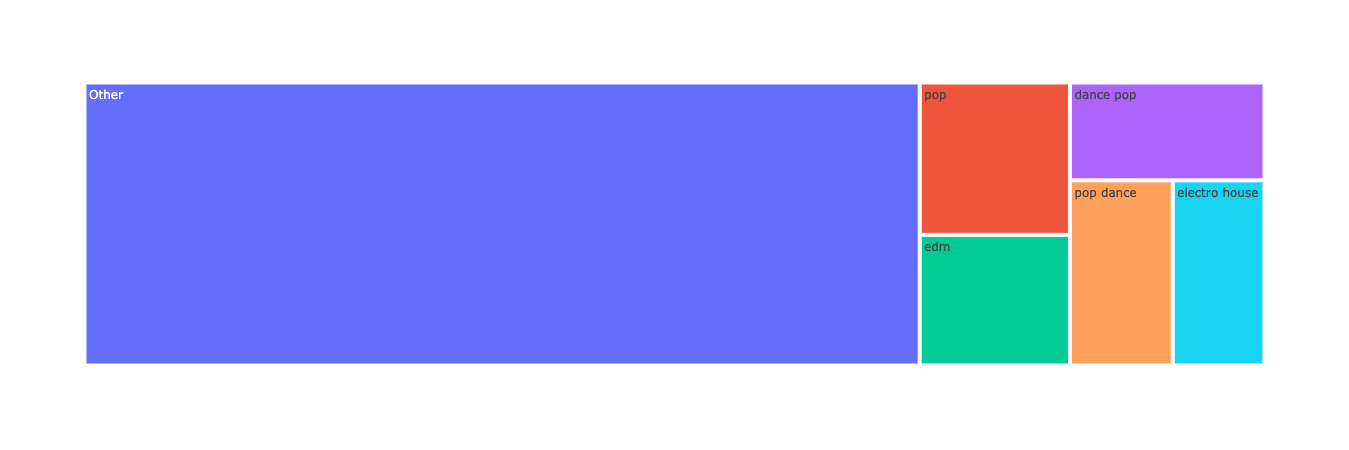

In [86]:
import plotly.express as px
fig = px.treemap(df_artist_detailed_genre, path=['genre_new'])
fig

In [87]:
df_artist_detailed_genre

,name,genre,genre_new
0,Tony Junior,big room,Other
1,Tony Junior,deep big room,Other
2,Tony Junior,dutch house,Other
3,Tony Junior,edm,edm
4,Tony Junior,electro house,electro house
...,...,...,...
2767,RANI,uk pop,Other
2768,SHY Martin,alt z,Other
2769,SHY Martin,electropop,Other
2770,SHY Martin,pop,pop


In [89]:
df_saved_2 = df_saved.loc[df_saved['song_title'].str.contains('End', case=False, regex=False, na=False)]
df_saved_2

,acousticness,danceability,energy,speechiness,valence,BPM,song_title,artists,artists_url,date_added,album_cover,popularity,url,date_added_year
17,0.229000,0.469,0.497,0.0301,0.147,144.945,Surrender,"Culture Code,Aloma Steele","2FF8wcGpikv5RFbAK1rvdZ,0Th7ebqyWRIwNfNDIkEpNX",2021-05-16,https://i.scdn.co/image/ab67616d0000b273dc2717...,33,6uWqUaSwMjdXstqYICzIOj,2021
12,0.097200,0.725,0.447,0.0466,0.369,100.993,No One Nobody (feat. Tannergard) - Extended Mix,"LVNDSCAPE,Tannergard","2QlwnS23KrBeshXFyK5U6M,5SkFO3lmDnuFTMIOMK8Bxj",2020-05-19,https://i.scdn.co/image/ab67616d0000b273dd2f9a...,13,35FBQRowt0ysnLxRdnKTQi,2020
12,0.433000,0.448,0.603,0.0640,0.422,205.272,Lover (Remix) [feat. Shawn Mendes],"Taylor Swift,Shawn Mendes","06HL4z0CvFAxyc27GXpf02,7n2wHs1TKAczGzO7Dd2rGr",2020-03-19,https://i.scdn.co/image/ab67616d0000b27359457b...,72,3i9UVldZOE0aD0JnyfAZZ0,2020
8,0.267000,0.810,0.700,0.0399,0.193,116.019,End of Time,"K-391,Alan Walker,Ahrix","6pWcSL9wSJZQ9ne0TnhdWr,7vk5e3vY1uw9plTHJAMwjN,...",2020-03-06,https://i.scdn.co/image/ab67616d0000b27349b9fb...,71,67O8CWXxPsfz8orZVGMQwf,2020
16,0.080300,0.677,0.737,0.1010,0.529,126.076,Can We Pretend (feat. Cash Cash) - MOTi Remix,"P!nk,Cash Cash,MOTi","1KCSPY1glIKqW2TotWuXOR,1LOB7jTeEV14pHai6EXSzF,...",2019-09-22,https://i.scdn.co/image/ab67616d0000b27325a9ca...,31,6wOGUUk5ys4jDEjUN5Xj1x,2019
19,0.446000,0.679,0.744,0.0305,0.523,117.994,Rendezvous,DEAMN,1Q50Y9cXWlkNEG6gJfUP1e,2019-08-17,https://i.scdn.co/image/ab67616d0000b273ab5191...,0,0CgoJjztyESsK4pq3UIIKI,2019
13,0.371000,0.666,0.720,0.0269,0.312,99.970,End Of The Night,Danny Avila,5y3G1B8cpCTaoq0uDgjwzH,2019-04-27,https://i.scdn.co/image/ab67616d0000b273c27d89...,60,46n9OJc7LOIVdj8t2l5WA5,2019
19,0.211000,0.491,0.693,0.0377,0.412,90.027,Hymn for the Weekend,Coldplay,4gzpq5DPGxSnKTe4SA8HAU,2019-04-11,https://i.scdn.co/image/ab67616d0000b2738ff7c3...,85,3RiPr603aXAoi4GHyXx0uy,2019
8,0.023600,0.542,0.894,0.0676,0.296,127.947,Surrender,Cash Cash,1LOB7jTeEV14pHai6EXSzF,2019-04-05,https://i.scdn.co/image/ab67616d0000b27359793c...,0,3rwdcyPQ37SSsf1loOpux9,2019
18,0.064800,0.724,0.702,0.0429,0.688,106.044,No New Friends,"Sia,Diplo,Labrinth,LSD","5WUlDfRSoLAfcVSX1WnrxN,5fMUXHkw8R8eOP2RNVYEZX,...",2019-03-27,https://i.scdn.co/image/ab67616d0000b2738dc455...,0,3Y7a0typ6ik1KscmebXd6D,2019
